In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.ensemble import IsolationForest


In [4]:
df = spark.read.csv('iot_telemetry_data.csv', header=True, inferSchema='true')

In [5]:
df.show(50)

+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|                  ts|           device|                  co|         humidity|light|                 lpg|motion|               smoke|              temp|
+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|1.5945120943859746E9|b8:27:eb:bf:9d:51|0.004955938648391245|             51.0|false| 0.00765082227055719| false| 0.02041127012241292|              22.7|
|1.5945120947355676E9|00:0f:00:70:91:0a|0.002840088607101...|             76.0|false|0.005114383400977071| false|0.013274836704851536|19.700000762939453|
|1.5945120980735729E9|b8:27:eb:bf:9d:51|0.004976012340421658|             50.9|false|0.007673227406398091| false| 0.02047512557617824|              22.6|
| 1.594512099589146E9|1c:bf:ce:15:ec:4d|0.004403026829699689|76.800003051757

In [6]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,ts,double
1,device,string
2,co,double
3,humidity,double
4,light,boolean
5,lpg,double
6,motion,boolean
7,smoke,double
8,temp,double


In [7]:
num_rows = df.count()  # Get the number of rows
num_cols = len(df.columns)  # Get the number of columns

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 405184
Number of columns: 9


In [8]:
#Exploring columns types
df.dtypes

[('ts', 'double'),
 ('device', 'string'),
 ('co', 'double'),
 ('humidity', 'double'),
 ('light', 'boolean'),
 ('lpg', 'double'),
 ('motion', 'boolean'),
 ('smoke', 'double'),
 ('temp', 'double')]

In [9]:
df.summary().show() # to get a summary of our data ,including data types, non-null counts

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              405184|           405184|              405184|            405184|              405184|              405184|            405184|
|   mean| 1.594858017296816E9|             NULL|0.004638844633114...| 60.51169396157384|0.007237125655056997|0.019263611784846073|22.453987345644418|
| stddev|  199498.39926572324|             NULL|0.001250026283485...|11.366489390798094|0.001444115678768...|0.004086130060122203| 2.698346951263282|
|    min|1.5945120943859746E9|00:0f:00:70:91:0a|0.001170508548437...| 1.100000023841858|0.0026934786

In [10]:
from pyspark.sql.functions import col, collect_set

# Get unique values in the 'co' column
unique_co_values = df.select(collect_set(col("co"))).first()[0]

print(unique_co_values)  # Print the unique values

[0.007402288384708557, 0.005253216281110569, 0.0052863329337583965, 0.005379482020022124, 0.0031469746575106023, 0.006334230638005041, 0.003716225875676691, 0.00565788096052568, 0.005162190356812204, 0.004993255943286525, 0.004472015168716246, 0.005253262237202548, 0.005606946569974279, 0.005738762713020438, 0.006334404530326588, 0.005256465977311079, 0.005205088327676322, 0.005287832821596487, 0.005122840452726268, 0.006523411158436317, 0.008468332549272897, 0.005103411097957684, 0.003626752758792218, 0.0037755606555880165, 0.005095807277639809, 0.006830461194718487, 0.005931650693730722, 0.0047618270416348646, 0.005687997838966415, 0.005889962008675906, 0.006311090751970718, 0.004962978951830503, 0.006816099888171512, 0.006285710403618899, 0.0054271071774048465, 0.00667980618230909, 0.0038972780036031, 0.00517122256028496, 0.01115551278897083, 0.004869030146992029, 0.006055902050486872, 0.006613326000353279, 0.005846676155669807, 0.006283833470354194, 0.006709887614767084, 0.00583002

In [11]:

for col in df.columns:
    print(col.ljust(20), df.filter(df[col].isNull()).count())


ts                   0
device               0
co                   0
humidity             0
light                0
lpg                  0
motion               0
smoke                0
temp                 0


In [12]:
from pyspark.sql.functions import count, col, expr

duplicate_count = df.groupBy(df.columns).count().filter(col("count") > 1).count()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 13


In [13]:
df = df.drop_duplicates()

In [14]:
from pyspark.sql.functions import to_timestamp

# Convert the 'ts' column to timestamp type
df = df.withColumn('ts', to_timestamp('ts'))

In [15]:
df.show(10)

+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|                  ts|           device|                  co|         humidity|light|                 lpg|motion|               smoke|              temp|
+--------------------+-----------------+--------------------+-----------------+-----+--------------------+------+--------------------+------------------+
|2020-07-12 00:14:...|b8:27:eb:bf:9d:51|0.004996121290982169|             48.8|false|0.007695646843981007| false| 0.02053903451653109|              22.1|
|2020-07-12 00:16:...|00:0f:00:70:91:0a|0.002840088607101...| 75.4000015258789|false|0.005114383400977071| false|0.013274836704851536|              19.5|
|2020-07-12 00:19:...|00:0f:00:70:91:0a|0.002731427737301...| 75.4000015258789|false|0.004972070075170033| false|0.012880641926037256|              19.5|
|2020-07-12 00:28:...|00:0f:00:70:91:0a| 0.00270098296935936|76.199996948242

In [16]:
pandas_df = df.toPandas()

In [17]:
features = ['temp', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'co']

iso_forest = IsolationForest(contamination=0.05, random_state=42)
pandas_df['is_anomaly'] = iso_forest.fit_predict(pandas_df[features])

# تعديل القيم: -1 = anomaly → 1, و 1 = normal → 0
pandas_df['is_anomaly'] = pandas_df['is_anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [18]:
pandas_df.head(100)

,ts,device,co,humidity,light,lpg,motion,smoke,temp,is_anomaly
0,2020-07-12 00:14:33.137729,b8:27:eb:bf:9d:51,0.004996,48.800000,False,0.007696,False,0.020539,22.100000,0
1,2020-07-12 00:16:59.960511,00:0f:00:70:91:0a,0.002840,75.400002,False,0.005114,False,0.013275,19.500000,0
2,2020-07-12 00:19:32.981495,00:0f:00:70:91:0a,0.002731,75.400002,False,0.004972,False,0.012881,19.500000,0
3,2020-07-12 00:28:13.738944,00:0f:00:70:91:0a,0.002701,76.199997,False,0.004932,False,0.012770,19.700001,0
4,2020-07-12 00:40:55.345317,b8:27:eb:bf:9d:51,0.005021,51.100000,False,0.007723,False,0.020617,22.600000,0
...,...,...,...,...,...,...,...,...,...,...
95,2020-07-12 10:16:44.833722,b8:27:eb:bf:9d:51,0.004894,52.200000,False,0.007582,False,0.020214,21.400000,0
96,2020-07-12 10:18:43.206875,b8:27:eb:bf:9d:51,0.004866,52.200000,False,0.007550,False,0.020125,21.400000,0
97,2020-07-12 10:39:05.289029,00:0f:00:70:91:0a,0.003006,75.800003,False,0.005328,False,0.013869,19.600000,0
98,2020-07-12 10:43:59.296551,00:0f:00:70:91:0a,0.003014,75.699997,False,0.005339,False,0.013899,19.700001,0


In [19]:
from pyspark.sql.functions import mean, stddev, abs, col
from pyspark.sql.types import NumericType

numerical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

stats = df.select([
    mean(c).alias(f"{c}_mean") for c in numerical_cols
] + [
    stddev(c).alias(f"{c}_stddev") for c in numerical_cols
]).collect()[0]

for c in numerical_cols:
    mean_val = stats[f"{c}_mean"]
    std_val = stats[f"{c}_stddev"]
    if std_val is not None:
        df = df.filter(abs(col(c) - mean_val) < std_val)

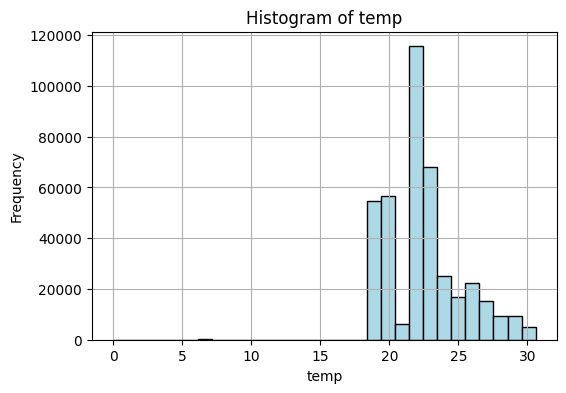

Temperature values are roughly normal with a peak around 22°C. Some high values may be outliers.


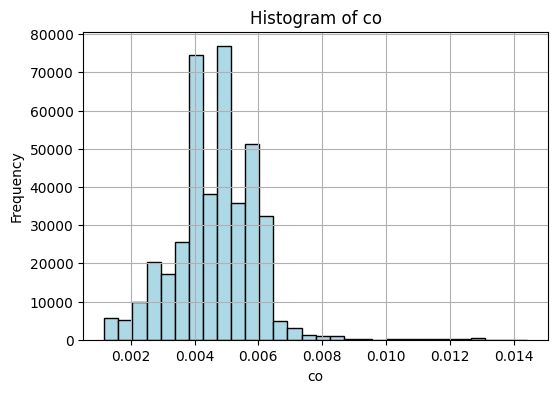

CO levels show multiple peaks, especially between 0.0050–0.0055. Some outliers are present.


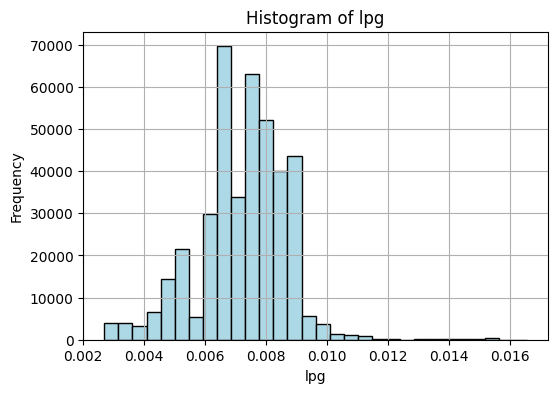

LPG data is multi-modal with peaks near 0.0078–0.0080. There are possible outliers.


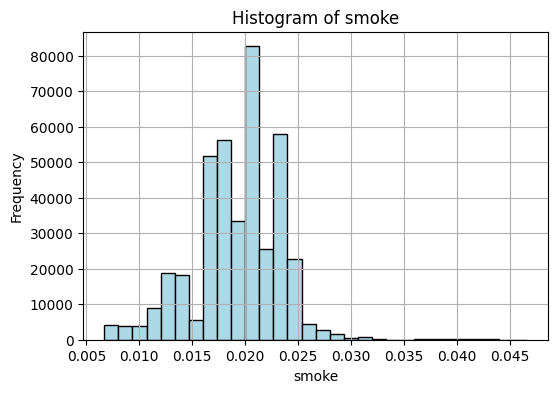

Smoke levels vary with peaks around 0.020–0.021. Some values could be outliers.


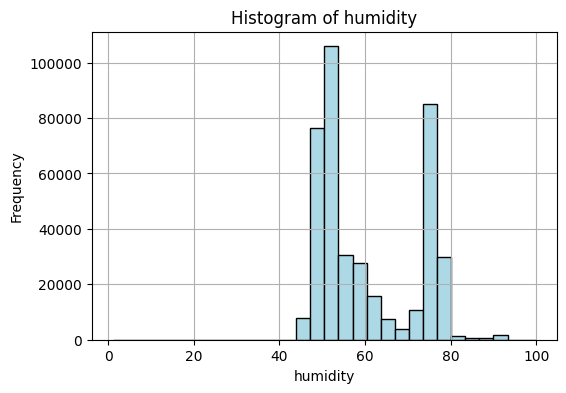

Humidity is left-skewed with most values near 50–52%. Some high values are potential outliers.


In [20]:
columns = ['temp', 'co', 'lpg', 'smoke', 'humidity']

for col in columns:
    plt.figure(figsize=(6, 4))
    plt.hist(pandas_df[col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    interpretation = {
    'temp': 'Temperature values are roughly normal with a peak around 22°C. Some high values may be outliers.',
    'co': 'CO levels show multiple peaks, especially between 0.0050–0.0055. Some outliers are present.',
    'lpg': 'LPG data is multi-modal with peaks near 0.0078–0.0080. There are possible outliers.',
    'smoke': 'Smoke levels vary with peaks around 0.020–0.021. Some values could be outliers.',
    'humidity': 'Humidity is left-skewed with most values near 50–52%. Some high values are potential outliers.'
}
    print(interpretation[col])

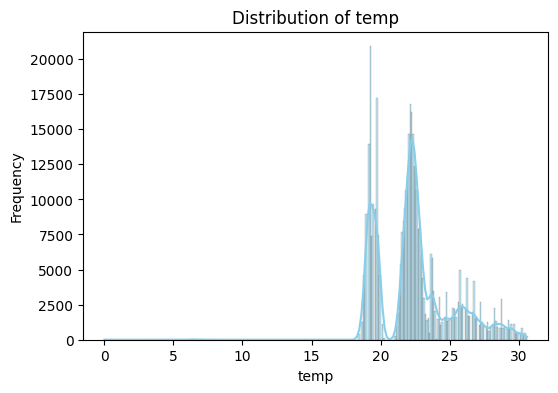

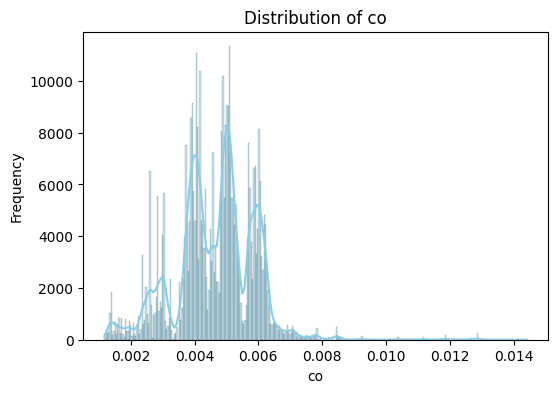

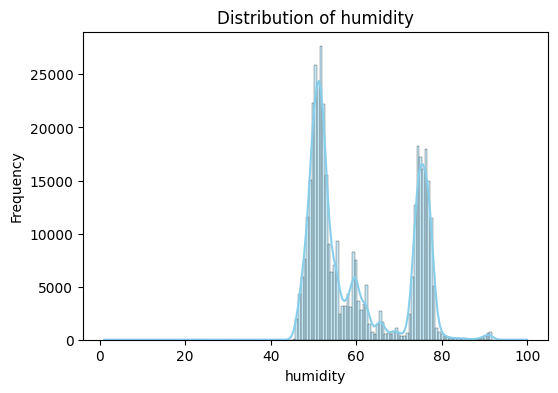

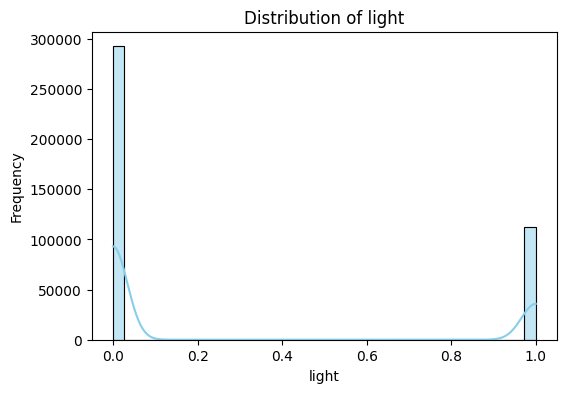

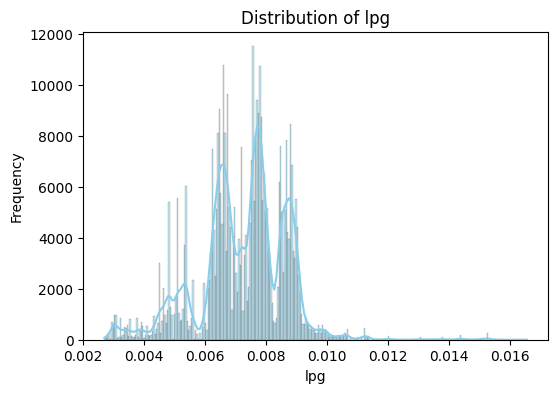

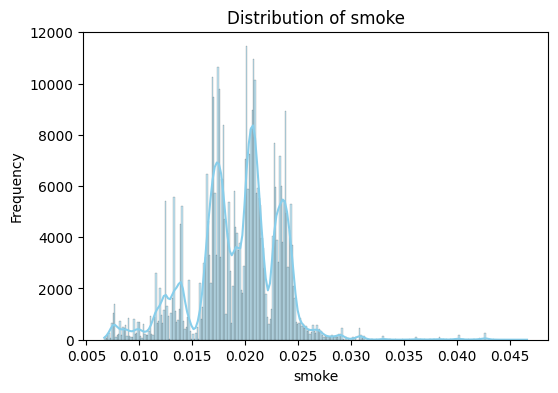

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

variables = ['temp', 'co', 'humidity', 'light', 'lpg', 'smoke']

for var in variables:
    plt.figure(figsize=(6, 4))
    sns.histplot(pandas_df[var], kde=True, color='skyblue')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

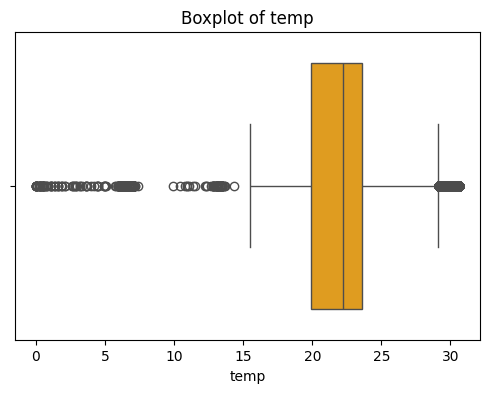

Temperature has several outliers on both the lower and upper ends. Most values are concentrated between 22 and 24 degrees, indicating a fairly normal distribution with slight extremes.


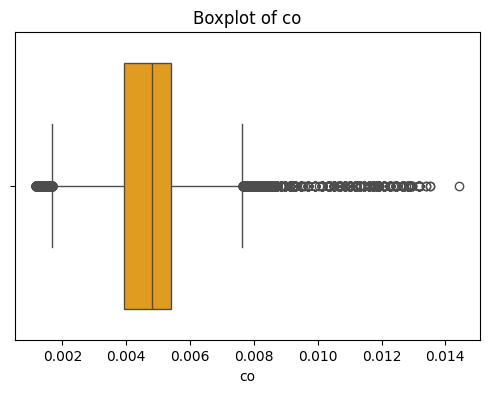

CO shows multiple low-end outliers, meaning some readings are significantly lower than the rest. The core distribution appears balanced.


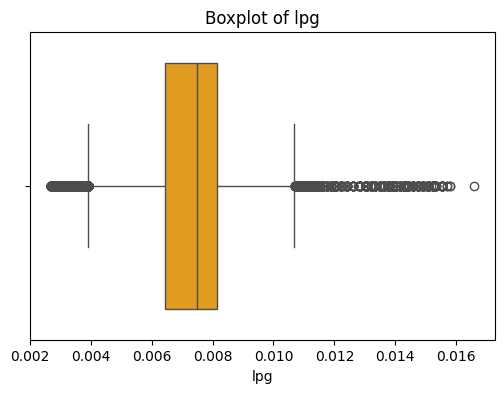

LPG has noticeable outliers on the lower side. The main values are symmetrically distributed, but some unusual low readings exist.


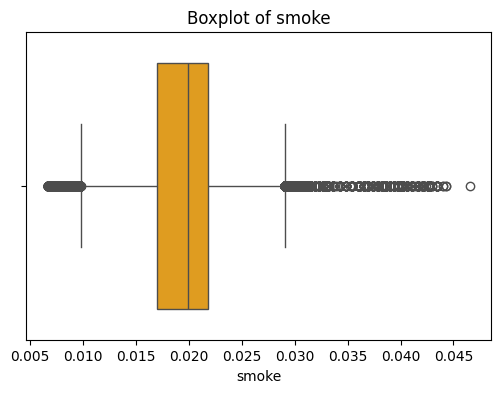

Smoke values have several low-end outliers. The majority of the data is stable, with occasional dips indicating rare low smoke events.


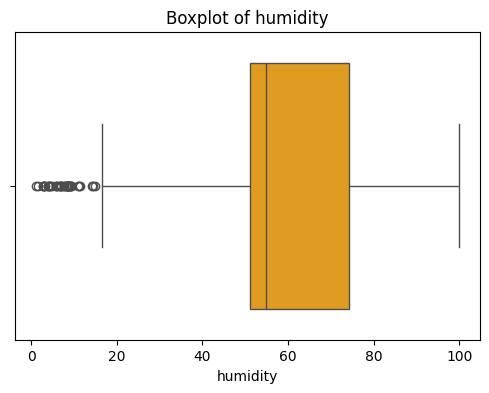

Humidity is right-skewed with many high-value outliers. This suggests that humidity can sometimes spike much higher than the average.


In [22]:
for var in ['temp', 'co', 'lpg', 'smoke', 'humidity']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=pandas_df[var], color='orange')
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)
    plt.show()

    boxplot_comments = {
    'temp': 'Temperature has several outliers on both the lower and upper ends. Most values are concentrated between 22 and 24 degrees, indicating a fairly normal distribution with slight extremes.',
    'co': 'CO shows multiple low-end outliers, meaning some readings are significantly lower than the rest. The core distribution appears balanced.',
    'lpg': 'LPG has noticeable outliers on the lower side. The main values are symmetrically distributed, but some unusual low readings exist.',
    'smoke': 'Smoke values have several low-end outliers. The majority of the data is stable, with occasional dips indicating rare low smoke events.',
    'humidity': 'Humidity is right-skewed with many high-value outliers. This suggests that humidity can sometimes spike much higher than the average.'
    }

    print(boxplot_comments[var])



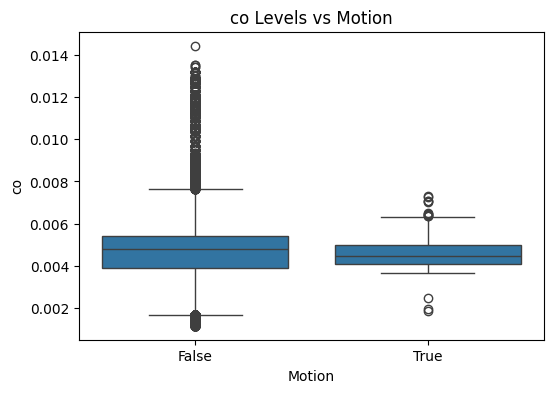

Interpretation: CO levels tend to be slightly lower and more spread out when motion is detected. In contrast, when there's no motion, CO values are slightly higher and have more low-end outliers, indicating less variability in air movement.


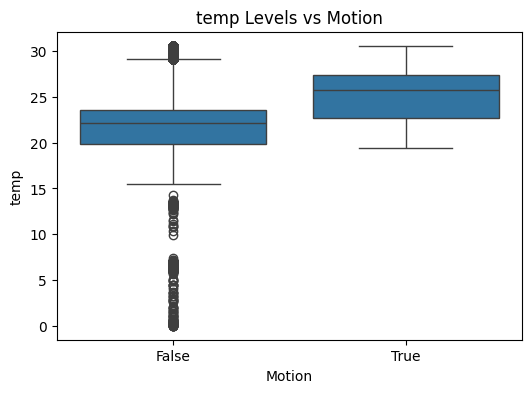

Interpretation: Temperature tends to be slightly higher when there is no motion, suggesting less ventilation or less environmental change. When motion is detected, temperatures are slightly lower and more consistent.


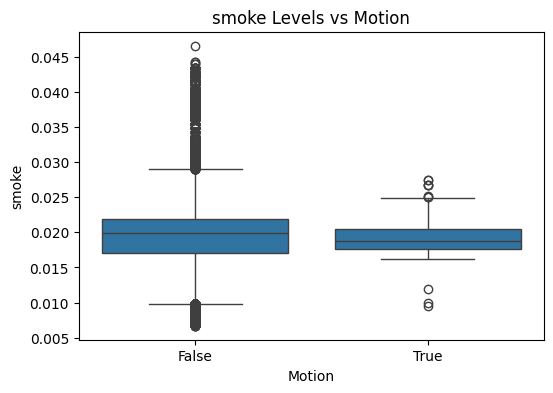

Interpretation: Smoke levels are slightly higher when no motion is detected, possibly due to stagnation in air flow. When motion is present, smoke concentrations tend to decrease, suggesting improved air circulation.


In [23]:
for var in ['co', 'temp', 'smoke']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='motion', y=var, data=pandas_df)
    plt.title(f'{var} Levels vs Motion')
    plt.xlabel('Motion')
    plt.ylabel(var)
    plt.show()

    if var == 'co':
        print("Interpretation: CO levels tend to be slightly lower and more spread out when motion is detected. In contrast, when there's no motion, CO values are slightly higher and have more low-end outliers, indicating less variability in air movement.")
    elif var == 'temp':
        print("Interpretation: Temperature tends to be slightly higher when there is no motion, suggesting less ventilation or less environmental change. When motion is detected, temperatures are slightly lower and more consistent.")
    elif var == 'smoke':
        print("Interpretation: Smoke levels are slightly higher when no motion is detected, possibly due to stagnation in air flow. When motion is present, smoke concentrations tend to decrease, suggesting improved air circulation.")
    else:
      print("g")

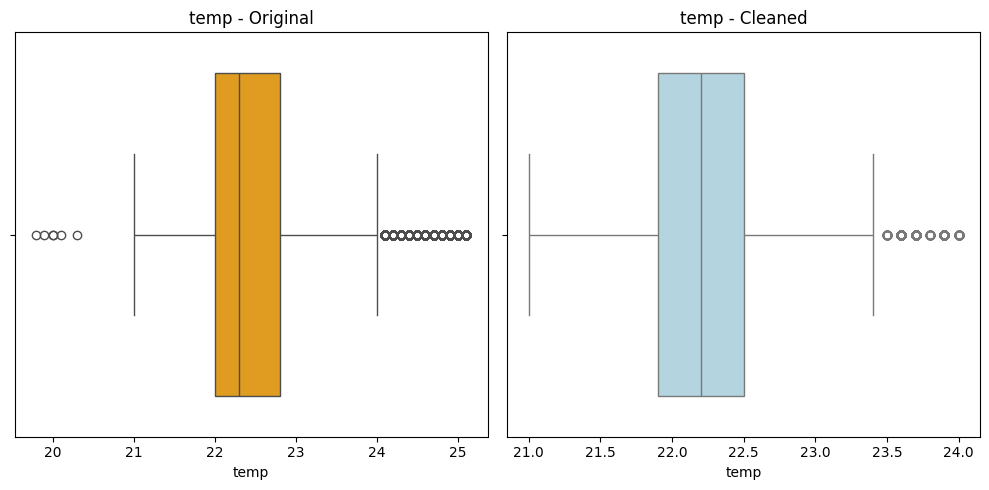

TEMP Interpretation:
After removing outliers, the temperature distribution appears more centered with fewer extreme values, suggesting a cleaner and more normal spread.



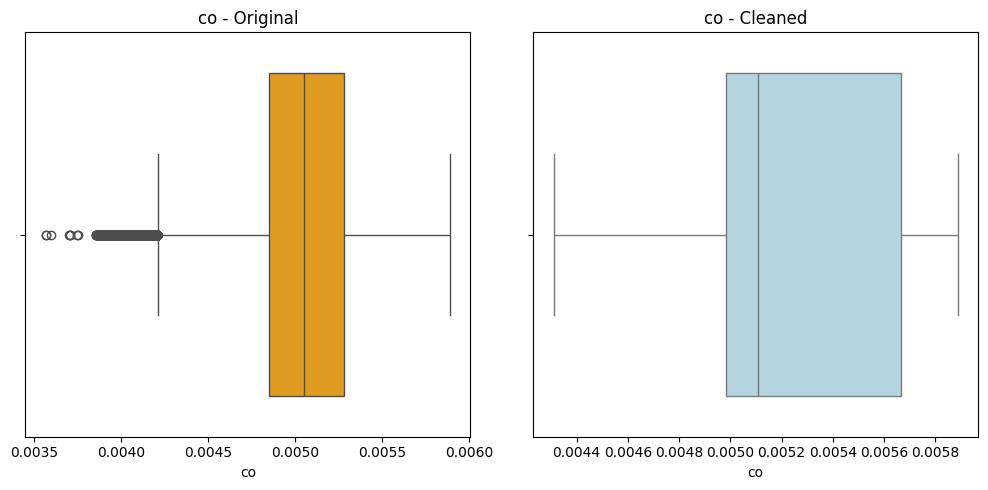

CO Interpretation:
The CO distribution is now more compact after removing extreme low and high values. The data now reflects a more stable concentration.



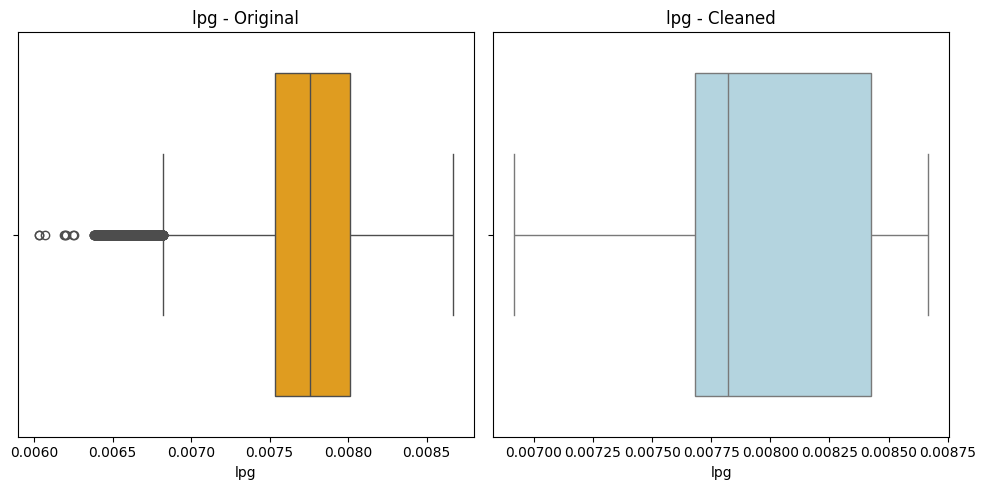

LPG Interpretation:
Unusual low LPG values were removed, making the distribution more symmetric and representative of typical readings.



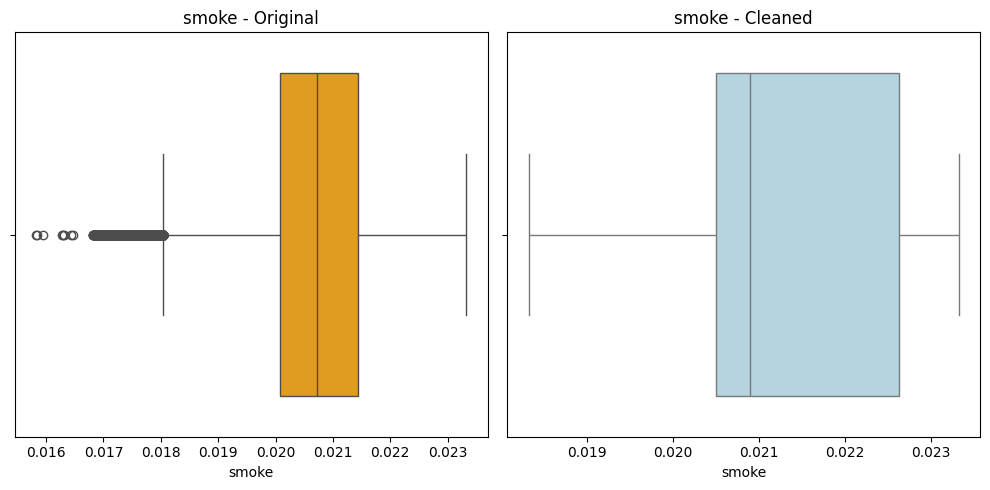

SMOKE Interpretation:
The cleaned smoke data shows less variation, indicating that rare dips in smoke levels have been filtered out.



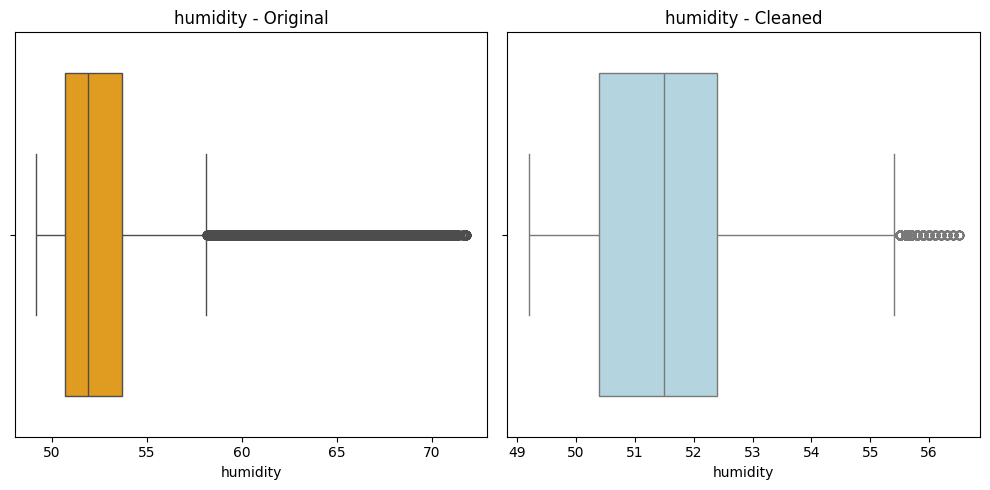

HUMIDITY Interpretation:
The cleaned humidity distribution is less right-skewed. Many high outlier values were removed, showing more typical humidity conditions.



In [24]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Save a copy of the original DataFrame
df_original = df

# Step 2: Remove outliers using IQR method
cols = ['temp', 'co', 'lpg', 'smoke', 'humidity']
df_cleaned = df_original

for col_name in cols:
    q1, q3 = df_cleaned.approxQuantile(col_name, [0.25, 0.75], 0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_cleaned = df_cleaned.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

# Step 3: Convert both DataFrames to Pandas
pandas_original = df_original.toPandas()
pandas_cleaned = df_cleaned.toPandas()

# Step 4: Visualization + Interpretation
boxplot_comments = {
    'temp': 'After removing outliers, the temperature distribution appears more centered with fewer extreme values, suggesting a cleaner and more normal spread.',
    'co': 'The CO distribution is now more compact after removing extreme low and high values. The data now reflects a more stable concentration.',
    'lpg': 'Unusual low LPG values were removed, making the distribution more symmetric and representative of typical readings.',
    'smoke': 'The cleaned smoke data shows less variation, indicating that rare dips in smoke levels have been filtered out.',
    'humidity': 'The cleaned humidity distribution is less right-skewed. Many high outlier values were removed, showing more typical humidity conditions.'
}

for col_name in cols:
    plt.figure(figsize=(10, 5))

    # Original boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=pandas_original[col_name], color='orange')
    plt.title(f'{col_name} - Original')
    plt.xlabel(col_name)

    # Cleaned boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=pandas_cleaned[col_name], color='lightblue')
    plt.title(f'{col_name} - Cleaned')
    plt.xlabel(col_name)

    plt.tight_layout()
    plt.show()

    # Interpretation
    print(f"{col_name.upper()} Interpretation:\n{boxplot_comments[col_name]}\n")


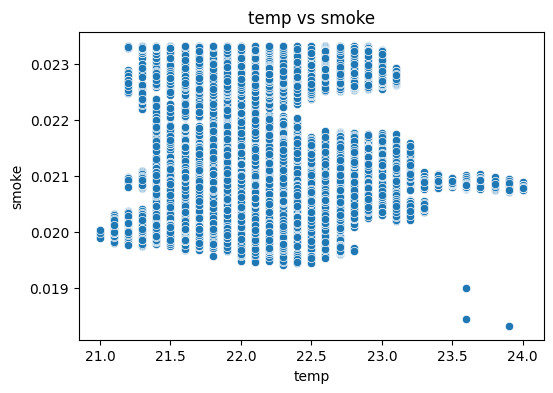

There appears to be a weak negative correlation between temperature and smoke. As temperature increases, the smoke concentration slightly decreases. However, the relationship is not strong or clearly linear.


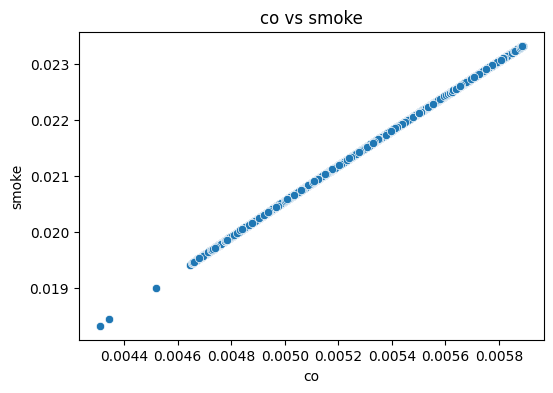

There is a very strong positive linear correlation between CO and smoke levels. As CO concentration increases, smoke levels also increase proportionally.


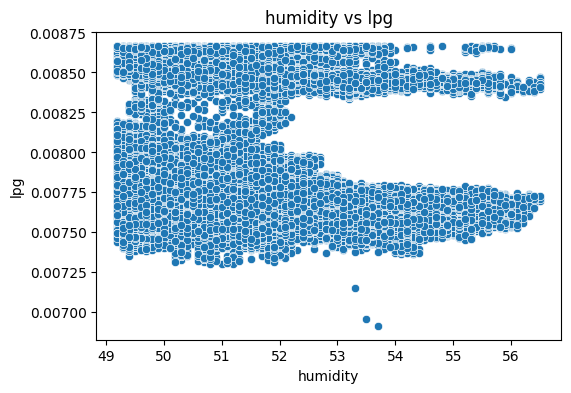

There is no clear or strong correlation between humidity and LPG levels.The data points are scattered without a consistent pattern


In [25]:
pair_list = [('temp', 'smoke'), ('co', 'smoke'), ('humidity', 'lpg')]

for x, y in pair_list:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, data=pandas_cleaned)
    plt.title(f'{x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

    if (x, y) == ('temp', 'smoke'):
        comment = 'There appears to be a weak negative correlation between temperature and smoke. As temperature increases, the smoke concentration slightly decreases. However, the relationship is not strong or clearly linear.'
    elif (x, y) == ('co', 'smoke'):
        comment = 'There is a very strong positive linear correlation between CO and smoke levels. As CO concentration increases, smoke levels also increase proportionally.'
    elif (x, y) == ('humidity', 'lpg'):
        comment = 'There is no clear or strong correlation between humidity and LPG levels.The data points are scattered without a consistent pattern'
    else:
        comment = 'No clear correlation found.'

    print(comment)



In [26]:
cleaned_pandas_df = df_cleaned.toPandas()


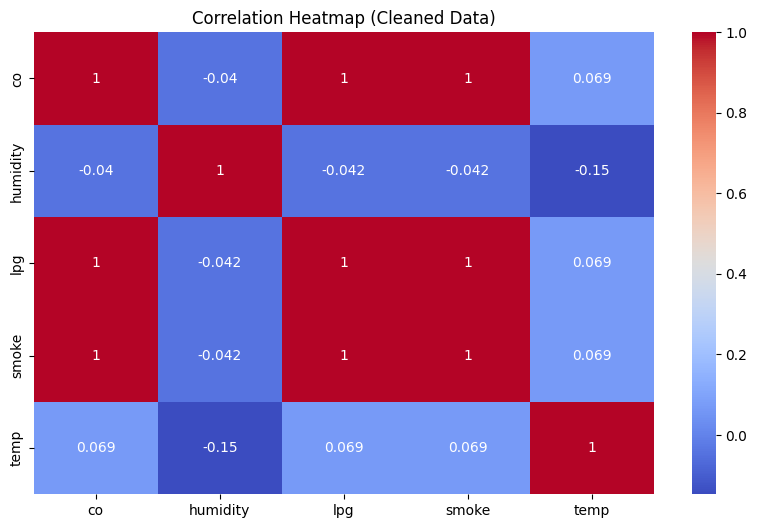

In [27]:
numeric_df = cleaned_pandas_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 6))
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Cleaned Data)')
plt.show()



The correlation heatmap illustrates the linear relationships between the cleaned dataset's features. Strong positive correlations (close to 1.0) are observed between CO, LPG, and Smoke, suggesting that these pollutants tend to increase or decrease together, possibly due to a shared source such as combustion processes.

On the other hand, Humidity shows a weak negative correlation with Temperature (-0.15), indicating that higher humidity levels might be slightly associated with lower temperatures. The remaining correlations between variables are weak or negligible, reflecting minimal linear relationships.

Overall, the heatmap highlights that air pollutant variables are highly interrelated, whereas environmental factors like temperature and humidity have less influence on those pollutant concentrations.




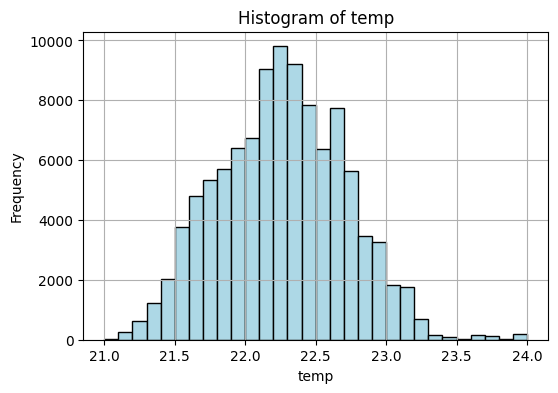


After outlier removal, the temperature values are approximately normally distributed,
with most observations centered around 22°C. This indicates stable and consistent
environmental conditions. The clean distribution suggests that temperature is a well-behaved
variable, suitable for statistical and predictive modeling.



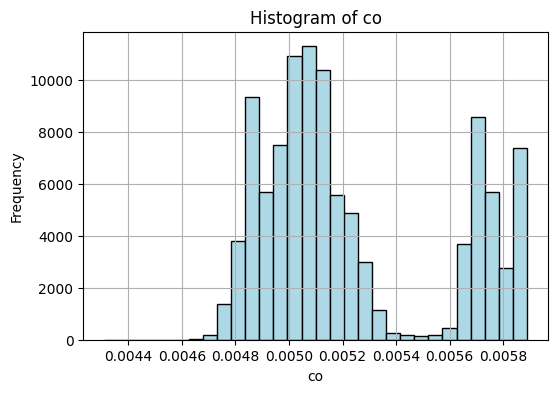


After removing outliers, the distribution of carbon monoxide (CO) appears slightly multimodal,
suggesting recurring patterns or operational phases in the data. Despite the multiple peaks,
the values fall within a reasonable range, and the absence of extreme outliers confirms
the reliability of this variable for further analysis.



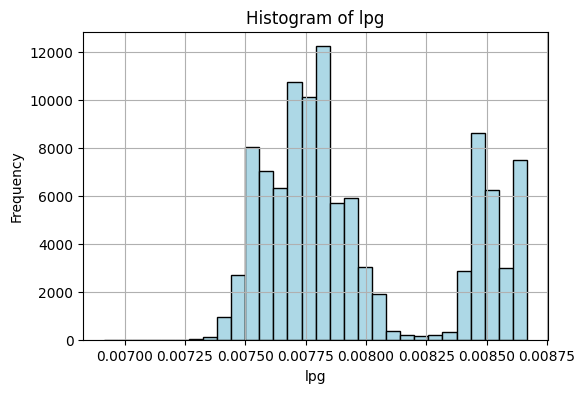


Following outlier removal, the LPG (liquefied petroleum gas) levels exhibit a multimodal distribution,
possibly reflecting varying environmental or operational conditions. The distribution is clean and compact,
without any significant extreme values, indicating a trustworthy and analyzable variable.



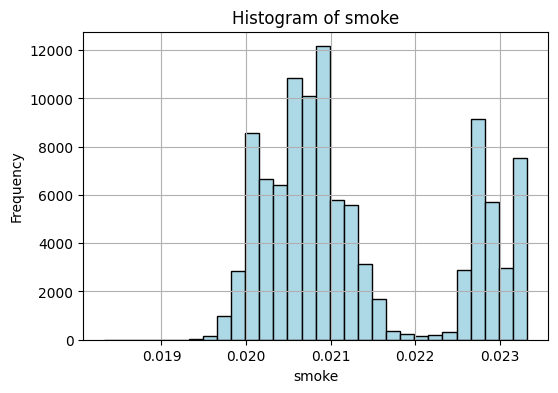


After outlier removal, smoke sensor readings show a bimodal distribution, which may indicate shifts
between different environmental states (e.g., clean vs. smoky air). The cleaned data reflects
a clear and interpretable pattern, suitable for modeling or classification tasks.



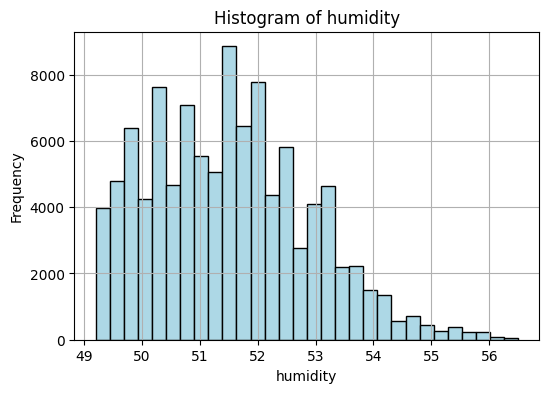


Humidity displays a right-skewed distribution after outlier removal, with most readings clustered
between 50% and 53%. The skewness reflects the natural variation in humidity, and the absence of
outliers ensures the variable is suitable for inclusion in further statistical analyses.



In [28]:
columns = ['temp', 'co', 'lpg', 'smoke', 'humidity']

for col in columns:
    plt.figure(figsize=(6, 4))
    plt.hist(cleaned_pandas_df[col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    comments = {
    'temp': """
After outlier removal, the temperature values are approximately normally distributed,
with most observations centered around 22°C. This indicates stable and consistent
environmental conditions. The clean distribution suggests that temperature is a well-behaved
variable, suitable for statistical and predictive modeling.
""",

    'co': """
After removing outliers, the distribution of carbon monoxide (CO) appears slightly multimodal,
suggesting recurring patterns or operational phases in the data. Despite the multiple peaks,
the values fall within a reasonable range, and the absence of extreme outliers confirms
the reliability of this variable for further analysis.
""",

    'lpg': """
Following outlier removal, the LPG (liquefied petroleum gas) levels exhibit a multimodal distribution,
possibly reflecting varying environmental or operational conditions. The distribution is clean and compact,
without any significant extreme values, indicating a trustworthy and analyzable variable.
""",

    'smoke': """
After outlier removal, smoke sensor readings show a bimodal distribution, which may indicate shifts
between different environmental states (e.g., clean vs. smoky air). The cleaned data reflects
a clear and interpretable pattern, suitable for modeling or classification tasks.
""",

    'humidity': """
Humidity displays a right-skewed distribution after outlier removal, with most readings clustered
between 50% and 53%. The skewness reflects the natural variation in humidity, and the absence of
outliers ensures the variable is suitable for inclusion in further statistical analyses.
"""
}
# Print the interpretation comment
    print(comments[col])

Machine Learning

In [32]:
spark_df = spark.createDataFrame(pandas_df)


In [33]:
indexer = StringIndexer(inputCol="device", outputCol="device_index")

feature_cols = ['device_index', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp', 'co']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [34]:
data_preprocessor = Pipeline(stages=[indexer, assembler])
processed_df = data_preprocessor.fit(spark_df).transform(spark_df)
final_data = processed_df.select('features', 'is_anomaly')

# تقسيم الداتا
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol='is_anomaly', predictionCol='prediction', metricName='accuracy')


In [36]:
# -------- Random Forest BEFORE Tuning --------
rf = RandomForestClassifier(labelCol="is_anomaly", featuresCol="features")
rf_simple_model = rf.fit(train_data)
rf_preds_before = rf_simple_model.transform(test_data)
rf_acc_before = evaluator.evaluate(rf_preds_before)
print(f"Random Forest Accuracy BEFORE tuning: {rf_acc_before:.2f}")

Random Forest Accuracy BEFORE tuning: 0.98


In [37]:
# -------- Decision Tree BEFORE Tuning --------
dt = DecisionTreeClassifier(labelCol="is_anomaly", featuresCol="features")
dt_simple_model = dt.fit(train_data)
dt_preds_before = dt_simple_model.transform(test_data)
dt_acc_before = evaluator.evaluate(dt_preds_before)
print(f"Decision Tree Accuracy BEFORE tuning: {dt_acc_before:.2f}")

Decision Tree Accuracy BEFORE tuning: 0.98


In [38]:
# -------- Logistic Regression BEFORE Tuning --------
lr = LogisticRegression(labelCol="is_anomaly", featuresCol="features")
lr_simple_model = lr.fit(train_data)
lr_preds_before = lr_simple_model.transform(test_data)
lr_acc_before = evaluator.evaluate(lr_preds_before)
print(f"Logistic Regression Accuracy BEFORE tuning: {lr_acc_before:.2f}")

Logistic Regression Accuracy BEFORE tuning: 0.99


In [39]:
# -------- Random Forest AFTER Tuning --------
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [50, 100])
                .addGrid(rf.maxDepth, [5, 10])
                .build())

rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

rf_model_tuned = rf_cv.fit(train_data)
rf_preds_after = rf_model_tuned.transform(test_data)
rf_acc_after = evaluator.evaluate(rf_preds_after)
print(f"Random Forest Accuracy AFTER tuning: {rf_acc_after:.2f}")

Random Forest Accuracy AFTER tuning: 0.98


In [40]:
# -------- Decision Tree AFTER Tuning --------
dt_paramGrid = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10, 15])
                .build())

dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

dt_model_tuned = dt_cv.fit(train_data)
dt_preds_after = dt_model_tuned.transform(test_data)
dt_acc_after = evaluator.evaluate(dt_preds_after)
print(f"Decision Tree Accuracy AFTER tuning: {dt_acc_after:.2f}")

Decision Tree Accuracy AFTER tuning: 0.99


In [41]:
# -------- Logistic Regression AFTER Tuning --------
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 0.5])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

lr_model_tuned = lr_cv.fit(train_data)
lr_preds_after = lr_model_tuned.transform(test_data)
lr_acc_after = evaluator.evaluate(lr_preds_after)
print(f"Logistic Regression Accuracy AFTER tuning: {lr_acc_after:.2f}")

Logistic Regression Accuracy AFTER tuning: 0.95
